# Setting up enviroment and read data

In [1]:
#Import packages
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import initializers
from torchcrf import CRF
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import math
from sklearn.utils import shuffle
import random

In [2]:
#Read raw data
def read_data(f_path):
    tokenizer_data_preprocessing = AutoTokenizer.from_pretrained('bert-base-uncased')
    raw_data = open(f_path).read()
    token_instance = []
    label_instance = []
    raw_token = []
    raw_label = []
    for content in raw_data.split('\n'):

        if content != '':
            token_instance.append(content.split('\t')[0])
            label_instance.append(content.split('\t')[1])

        else:
            if len(token_instance) < 60:
                if len(token_instance) <=0:
                    continue
                raw_token.append(token_instance)
                raw_label.append(label_instance)
                token_instance = []
                label_instance = []
            else:

                pos = [0]
                for i, token in enumerate(token_instance):
                    if i == len(token_instance) - 1:
                        break
                    if (token == '.' and token_instance[i+1][0].isupper()) or token == ';' or token == ':' :
                        pos.append(i+1)
                    if len(token) > 2 and not token[1].isupper() and token[0].isupper() and len(tokenizer_data_preprocessing(token).data['input_ids']) - 2 == 1 and i - pos[-1] > 10:
                        pos.append(i)

                pos.append(len(token_instance)-1)
                for j, p in enumerate(pos):
                    if j == len(pos) - 1:
                        break
                    if pos[j+1] - pos[j] > 60 or pos[j+1] - pos[j] <= 0:
                        continue
                    raw_token.append(token_instance[pos[j]:pos[j+1]])
                    raw_label.append(label_instance[pos[j]:pos[j+1]])
                token_instance = []
                label_instance = []

    label_map = {'O': 0, 'B-Condition': 1, 'I-Condition': 2}
    label_map_inver = {0: 'O', 1: 'B-Condition', 2: 'I-Condition'}
    
    #label_map = {'O': 0, 'B-Con': 1, 'I-Con': 2,'B-Side':3,'I-Side':4}
    #label_map_inver = {0: 'O', 1: 'B-Con', 2: 'I-Con', 3:'B-Side',4:'I-Side'}
    
    raw_label = raw_label[:-1]
    raw_token = raw_token[:-1]

    return raw_token, raw_label,label_map,label_map_inver
        
    
file_path = 'train_refine.txt'
raw_token, raw_label, label_map, label_map_inver = read_data(file_path)


# Data overview

/home/nlp-team-ui-test2/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

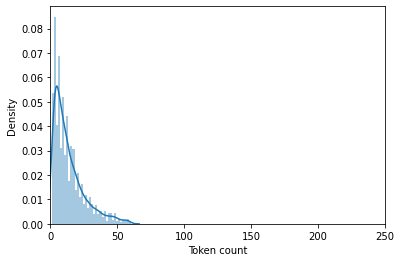

In [3]:
#Sentence length distribution
token_len = []
for sentence in raw_token:
    token_len.append(len(sentence))
token_len
sns.distplot(token_len)
plt.xlim([0, 250]);
plt.xlabel('Token count')

<BarContainer object of 3 artists>

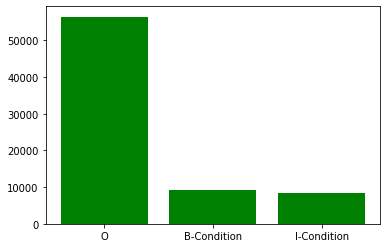

In [4]:
#Label category distirbution
def get_sent_label(raw_label):
    label_type = {}
    sentence_label_ls = []
    i = 0
    for labels in raw_label:
        sentence_label_dic = {}
        for label in labels:
            if label not in label_type:
                label_type[label] = (i, 1)
                sentence_label_dic[label] = 1
                i = i + 1
            else:
                label_type[label] = (label_type[label][0], label_type[label][1] + 1)
                if label in sentence_label_dic:
                    sentence_label_dic[label] = sentence_label_dic[label] + 1
                else: 
                    sentence_label_dic[label] = 1
        sentence_label_ls.append(sentence_label_dic)
    return sentence_label_ls,label_type

sentence_label_ls, label_type = get_sent_label(raw_label)
label_num = len(label_type)
plt.bar([x for x in label_type.keys()], [y[1] for y in label_type.values()], color = 'green')

In [5]:
label_type.values()

dict_values([(0, 56472), (1, 9349), (2, 8500)])

/home/nlp-team-ui-test2/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

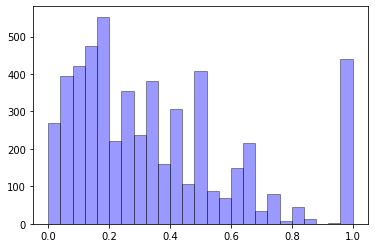

In [6]:
#Sentence level label distribution
labeled_proportion = [1 - x['O']/sum(x.values()) if 'O' in x else 1 for x in sentence_label_ls]
sns.distplot(labeled_proportion, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [7]:
#Remove sentence that don't have any entity in it
def remove_empty(sentence_label_ls):
    processed_raw_label = []
    processed_raw_token = []
    for x,y,z in zip(sentence_label_ls, raw_label, raw_token):
        # Remove sentence that has 0 entity
        if 'B-Condition' in x or 'I-Condition' in x:# or 'B-Side' in x or 'I-Side' in x:
            processed_raw_label.append(y)
            processed_raw_token.append(z)
    return processed_raw_label, processed_raw_token
processed_raw_label, processed_raw_token = remove_empty(sentence_label_ls)

<AxesSubplot:>

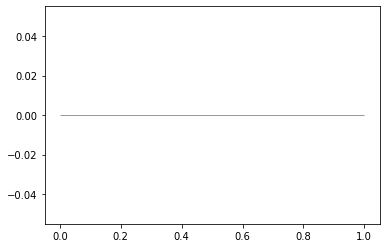

In [8]:
#Entity distribution
entity_len = []
last_label = ''
i = 0
for labels in processed_raw_label:
    i = i + 1
    for label in labels:
        if last_label == '':
            last_label = label
            continue
        elif label == 'O':
            if last_label == 'O':
                continue
            elif last_label == 'B-Con-Single':
                entity_len.append(en_len)
                last_label = 'O'
                en_len = 0
            else:
                entity_len.append(en_len)
                last_label = 'O'
                en_len = 0
        elif label == 'B-Con-Single':
            if last_label == 'O':
                last_label = 'B-Con-Single'
                en_len = 1
            elif last_label == 'B-Con-Single':
                entity_len.append(en_len)
                en_len = 1
            else:
                entity_len.append(en_len)
                last_label = 'B-Con-Single'
                en_len = 1
        else:
            if last_label == 'O':
                continue
            elif last_label == 'B-Con-Single':
                en_len = en_len + 1
                last_label = 'I-Con-Single'
            else:
                en_len = en_len + 1          

sns.distplot(entity_len, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})

# Data preprocessing

In [9]:
#Combine raw data to dataframe
All_data = pd.DataFrame()
All_data['input_token'] = processed_raw_token
All_data['input_label'] = processed_raw_label
All_data

,input_token,input_label
0,"[Severe, coagulopathy]","[O, B-Condition]"
1,"[Cardiovascular, disease, such, as, arrythmia,...","[B-Condition, I-Condition, O, O, B-Condition, ..."
2,"[Untreated, hyperthyroidism, ,, or, hypothyroi...","[O, B-Condition, O, O, B-Condition, O]"
3,"[2., Healthy, subjects, aged, between, 18, yea...","[O, B-Condition, O, O, O, O, O, O, O, O, O]"
4,"[Pregnancy, or, lactation]","[B-Condition, O, B-Condition]"
...,...,...
5259,"[Contraindication, to, anticoagulation, (, i.e...","[B-Condition, O, O, O, O, O, O, O, O, O, O, O,..."
5260,"[Pulmonary, disease]","[B-Condition, I-Condition]"
5261,"[Has, had, prior, systemic, therapy, for, HCC,...","[O, O, O, O, O, O, B-Condition, O, O, O, O, O,..."
5262,[Pregnant],[B-Condition]


In [10]:
def make_dense(All_data):
    keep_sentence = []
    keep_label = []
    for (i,x) in enumerate(All_data['input_label']):

        o_num = 0
        b_num = 0
        i_num = 0

        for y in x:
            if y == 'O':
                o_num = o_num +1
            elif y == 'B-Condition' or y == 'B-Side':
                b_num = b_num + 1
            elif y =='I-Condition' or y == 'I-Side':
                i_num = i_num + 1

        if (b_num+i_num)/(o_num+b_num+i_num) > 0.05:
            keep_sentence.append(All_data['input_token'][i])
            keep_label.append(All_data['input_label'][i])

    return keep_sentence, keep_label
keep_sentence, keep_label = make_dense(All_data)
All_data = pd.DataFrame()
All_data['input_token'] = keep_sentence
All_data['input_label'] = keep_label

In [11]:
All_data

,input_token,input_label
0,"[Severe, coagulopathy]","[O, B-Condition]"
1,"[Cardiovascular, disease, such, as, arrythmia,...","[B-Condition, I-Condition, O, O, B-Condition, ..."
2,"[Untreated, hyperthyroidism, ,, or, hypothyroi...","[O, B-Condition, O, O, B-Condition, O]"
3,"[2., Healthy, subjects, aged, between, 18, yea...","[O, B-Condition, O, O, O, O, O, O, O, O, O]"
4,"[Pregnancy, or, lactation]","[B-Condition, O, B-Condition]"
...,...,...
5066,"[Person, has, a, history, of, chronic, skin, b...","[O, O, O, O, O, O, B-Condition, I-Condition, O..."
5067,"[Contraindication, to, anticoagulation, (, i.e...","[B-Condition, O, O, O, O, O, O, O, O, O, O, O,..."
5068,"[Pulmonary, disease]","[B-Condition, I-Condition]"
5069,[Pregnant],[B-Condition]


In [12]:
#Preprocessing token using BERT tokenizer
def convert_single_example(tokenizer, max_len, input_tokens, input_labels):
    
    pre_labels = ['O']
    pre_tokens = ['[CLS]']
    mask = [True]
    token_embed = [[0]*max_len]
    start = 1
    for i, word in enumerate(input_tokens):
        token = tokenizer.tokenize(word)
        if len(token) == 0:
            token = [0]
        pre_tokens.extend(token)
        pre_lable = input_labels[i]
        p_num = 0 
        
        assert len(token) != 0,print(i)
        
        for _ in range(len(token)):
            
            p_num = p_num + 1
            
            pre_labels.append(pre_lable)
            mask.append(True)
        embed = [0]*max_len
        embed[start: start + p_num] =[1] + [0]*(p_num - 1) 
        token_embed.append(embed)
        start = start + p_num
        
    pre_tokens.append('[SEP]')    
    pre_labels.append('O')
    mask.append(False)
    token_embed.append([0]*max_len)
    
    assert len(pre_labels) == len(mask)
    #assert len(pre_labels) == len(token_embed)
    
    input_ids = tokenizer.convert_tokens_to_ids(pre_tokens)
    
    while len(input_ids) < max_len:
        input_ids.append(0)
    
    
    labels_id = []        
    for i, label in enumerate(pre_labels):
        labels_id.append(label_map[label])
    while len(labels_id) < max_len:
        labels_id.append(0)
        mask.append(False)
        
    while len(token_embed) < max_len:
        token_embed.append([0]*max_len)
        

    
    assert len(input_ids) == max_len
    assert len(labels_id) == max_len
    assert len(mask) == max_len
    assert len(token_embed) == max_len
    
    return {'input_ids': input_ids, 'labels_id': labels_id, 'mask': mask, 'token_embed': token_embed}

In [13]:
def convert_to_df(df, MAX_LEN, tokenizer):
    new_df = pd.DataFrame()
    processed_token_id = []
    processed_label_id = []
    mask = []
    token_embed = []
    
    for i in range(len(df)):
        result_dic = convert_single_example(tokenizer, MAX_LEN, df['input_token'][i], df['input_label'][i])
        processed_token_id.append(result_dic['input_ids'])
        processed_label_id.append(result_dic['labels_id'])
        mask.append(result_dic['mask'])
        token_embed.append(result_dic['token_embed'])
        
    new_df['token_id'] = processed_token_id
    new_df['token_embed'] = token_embed   
    new_df['label_id'] = processed_label_id
    new_df['mask'] = mask
    new_df['index'] = list(df.index) 
    
    return new_df

In [14]:
#Load BERT tokenizer
MAX_LEN = 128
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
processed_df = convert_to_df(All_data, MAX_LEN, tokenizer)

In [15]:
processed_df = shuffle(processed_df)
cross_val = {}
block_size = int(processed_df.shape[0]/16)
for i in range(16):
    if i == 15:
        cross_val[i] = processed_df[15*block_size:]
    else:
        cross_val[i] = processed_df[i*block_size: (i+1)*block_size]

In [16]:
#Create data loader for training, valadating and testing
class ChiaDataset(Dataset):
    def __init__(self, token_ls,label_ls, mask_ls, token_embed_ls,index):
        self.input_ids = token_ls
        self.label_ids = label_ls
        self.mask = mask_ls
        self.token_embed = token_embed_ls
        self.index = index
  
    def __len__(self):
        return len(self.label_ids)
  
    def __getitem__(self, item):
        token_ids = self.input_ids[item]
        label_ids = self.label_ids[item]
        mask_ids = self.mask[item]
        token_ebd = self.token_embed[item]
        index = self.index[item]
        
        return {
      'label_ids': torch.tensor(label_ids, dtype=torch.long),
      'input_ids': torch.tensor(token_ids),
      'mask': torch.tensor(mask_ids),
      'token_embed': torch.tensor(token_ebd),
      'index':torch.tensor(index)
    }

# Create  model

In [17]:
class CRFmodel(nn.Module):
    def __init__(self, embedding_dim, tag_size, lm):
        super().__init__()
        
        self.fc1 = nn.Linear(768, tag_size)
        self.tanh = nn.Tanh()
        self.crf = CRF(tag_size, batch_first = True)
        self.lm = lm
        self.drop = nn.Dropout(0.7)
        
        
    def forward(self, input_ids, labels, mask):

        embedding = self.lm(input_ids)[0]
        
        drop = self.drop(embedding)
        score = self.fc1(drop)
    
        
        z = self.tanh(score)    
        
        labels = labels[: ,1: ]
        mask = mask[: ,1: ]  
        z = z[: ,1:,:]
        x = self.crf(z, labels, mask = mask)

        return x

    def pred(self, input_ids, mask, token_embed):

        embedding = self.lm(input_ids)[0]     

        drop = self.drop(embedding)
        score = self.fc1(drop)
        
        z = self.tanh(score)         
        z = z[: ,1:,:]
        mask_ = mask[: ,1: ]
        x = self.crf.decode(z, mask = mask_)
        y = [[0] + u + [0]*(127-len(u)) for u in x]
        pred_mat = torch.tensor(y)
        label_trans = pred_mat.to(device)
        result = torch.matmul(token_embed.float(),label_trans.view(-1,128,1).float()).view(-1,128)
        result_ls = []
        mask_trans = mask.to(device)
        mask_pred = torch.matmul(token_embed.float(),mask_trans.view(-1,128,1).float()).view(-1,128).bool()
        for i in range(result.shape[0]):
            temp_ls = result[i][mask_pred[i]]
            result_ls.append(temp_ls.tolist())
        
        return result_ls

# Train model

In [18]:
def train(model,data_loader, optimizer, device):
    losses = []
    i = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        label_ids = d['label_ids'].to(device)
        mask = d['mask'].to(device)
        token_embed = d['token_embed'].to(device)

        loss = - model(input_ids,label_ids, mask)

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        scheduler.step()
        
    return np.mean(losses)

In [19]:
def prediction(model, data_loader, output_dir, cross_val_num,df):
    preds = []
    f = open(output_dir, 'w')
    f1 = open('result/' + 'cross_val_num{}'.format(cross_val_num) + output_dir, 'w')
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        label_ids_split = d['label_ids'].to(device)
        mask = d['mask'].to(device)
        token_embed = d['token_embed'].to(device)
        id_list = d['index']
        label_trans = label_ids_split.to(device)
        
        label_ids = torch.matmul(token_embed.float(),label_trans.view(-1,128,1).float()).view(-1,128)
        mask_trans = mask.to(device)
        mask_pred = torch.matmul(token_embed.float(),mask_trans.view(-1,128,1).float()).view(-1,128).bool()
        pred = model.pred(input_ids,mask, token_embed)
        assert type(pred) == list, 'not a list'
        #write prediction result

        for i, _ in enumerate(pred):
            
            label_line = []
            pred_line = []
            word_line = df['input_token'][int(id_list[i])]
            label_line_ = list(np.array(label_ids[i][1:][mask_pred[i][1:].cpu()].cpu()))

            for j in range(len(label_line_)):
                f.write(word_line[j] + ' ' + label_map_inver[label_line_[j]] + ' ' + label_map_inver[_[j]])
                f.write('\n')
                
            label_line = []
            pred_line = []

            for pred_label in _:
                pred_line.append(label_map_inver[pred_label])
            
            for x in label_line_:
                label_line.append(label_map_inver[x])

            assert len(label_line) == len(pred_line)
            
            f1.write('\t'.join(word_line) + '\n' )
            f1.write('\t'.join(label_line) + '\n')
            f1.write('\t'.join(pred_line) + '\n')
            f1.write('\n')
    
    return 0

In [20]:
#Start training
def train_epoch(crfmodel, train_data_loader,eval_data_loader,test_data_loader, optimizer, device,df,test_df):
    
    weight_score = -math.inf

    for epoch in range(EPOCHS):

        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_loss = train(crfmodel, train_data_loader, 
                                      optimizer, device)

        
        prediction(crfmodel, eval_data_loader, 'bert-pubmed.txt', cross_val_num,df) 
        result = !perl conlleval.pl < 'bert-pubmed.txt'
        precision = result[1].split(';')[1].split(':')[1].strip()
        recall = result[1].split(';')[2].split(':')[1].strip()
        F1_score = result[1].split(';')[3].split(':')[1].strip()        
        print(result)
        
        prediction(crfmodel, test_data_loader, 'covid_result.txt', cross_val_num,test_df) 
        result = !perl conlleval.pl < 'covid_result.txt'
        precision = result[1].split(';')[1].split(':')[1].strip()
        recall = result[1].split(';')[2].split(':')[1].strip()
        F1_score_test = result[1].split(';')[3].split(':')[1].strip()        
        print(result)

        if float(F1_score) > weight_score:
            torch.save(crfmodel.state_dict(), 'crfmodel.bin')
            weight_score = float(F1_score)

In [21]:
def get_test(file_path):
    raw_token, raw_label, label_map, label_map_inver = read_data(file_path)

    sentence_label_ls, label_type = get_sent_label(raw_label)

    processed_raw_label, processed_raw_token = remove_empty(sentence_label_ls)

    test_data = pd.DataFrame()
    test_data['input_token'] = raw_token
    test_data['input_label'] = raw_label
    test_data

    keep_sentence, keep_label = make_dense(test_data)
    test_data = pd.DataFrame()
    test_data['input_token'] = keep_sentence
    test_data['input_label'] = keep_label

    tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed')
    test_data_convert = convert_to_df(test_data, MAX_LEN, tokenizer)
    return test_data_convert,test_data

In [22]:
cross_val_result = pd.DataFrame()
EPOCHS = 5
num_tags = len(label_map)
embedding_dim = 768
cross_val_precision = []
cross_val_recall = []
cross_val_F1_score = []
lm = AutoModel.from_pretrained('dmis-lab/biobert-v1.1', return_dict = True)
output_dir = 'bert-pubmed.txt'
crfmodel = CRFmodel(embedding_dim, num_tags, lm)
crfmodel = crfmodel.to(device)
iter_num = 5
torch.save(crfmodel.state_dict(), 'initial_model.bin')
test_data,test_df = get_test('test_covid_refine.txt')
test_data_loader= DataLoader(ChiaDataset(test_data['token_id'].to_numpy(),
                    test_data['label_id'].to_numpy(), test_data['mask'].to_numpy(),
                    test_data['token_embed'].to_numpy() ,test_data['index'].to_numpy()), 
                    batch_size = 2, num_workers = 4)
result_ls = []
for i in range(iter_num):
    cross_val_num = i
    
    crfmodel.load_state_dict(torch.load('initial_model.bin'))
    
    optimizer = torch.optim.Adam(crfmodel.parameters(), lr=5e-5)   
    cross_val_idx = set(range(16))
    t = random.sample(cross_val_idx, 1)[0]
    val_data = cross_val[t]
    cross_val_idx.remove(t)
    train_index = cross_val_idx
    train_data = pd.DataFrame()
    for j in train_index:
        train_data = train_data.append(cross_val[j])

    print('Successfully split data')
    
    train_data_loader= DataLoader(ChiaDataset(train_data['token_id'].to_numpy(),
                                         train_data['label_id'].to_numpy(), train_data['mask'].to_numpy(),
                                         train_data['token_embed'].to_numpy(),train_data['index'].to_numpy()), 
                             batch_size = 30, num_workers = 4)
    eval_data_loader= DataLoader(ChiaDataset(val_data['token_id'].to_numpy(),
                                         val_data['label_id'].to_numpy(), val_data['mask'].to_numpy(),
                                        val_data['token_embed'].to_numpy(),val_data['index'].to_numpy()), 
                             batch_size = 2, num_workers = 4)

    total_steps = len(train_data_loader) * EPOCHS

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=5,
      num_training_steps=total_steps
)

    train_epoch(crfmodel, train_data_loader,eval_data_loader,test_data_loader,optimizer, device, All_data,test_df)

    crfmodel.load_state_dict(torch.load('crfmodel.bin'))
    
    prediction(crfmodel, test_data_loader, 'covid_result.txt', cross_val_num,test_df)  
    
    result = !perl conlleval.pl < 'covid_result.txt'
    
    #precision = result[1].split(';')[1].split(':')[1].strip()
    #recall = result[1].split(';')[2].split(':')[1].strip()
    #F1_score = result[1].split(';')[3].split(':')[1].strip()
    
    #cross_val_F1_score.append(F1_score)
    #cross_val_precision.append(precision)
    #cross_val_recall.append(recall)
    #print('F1_score_{}: {}'.format(cross_val_num,F1_score))
    result_ls.append(result)

#cross_val_result['Precision'] = cross_val_precision
#cross_val_result['Recall'] = cross_val_recall
#cross_val_result['F1_score'] = cross_val_F1_score

Successfully split data
Epoch 1/5
----------
['processed 4121 tokens with 611 phrases; found: 629 phrases; correct: 506.', 'accuracy:  93.57%; precision:  80.45%; recall:  82.82%; FB1:  81.61', '        Condition: precision:  80.45%; recall:  82.82%; FB1:  81.61  629']
['processed 2812 tokens with 383 phrases; found: 448 phrases; correct: 320.', 'accuracy:  92.00%; precision:  71.43%; recall:  83.55%; FB1:  77.02', '        Condition: precision:  71.43%; recall:  83.55%; FB1:  77.02  448']
Epoch 2/5
----------
['processed 4121 tokens with 611 phrases; found: 653 phrases; correct: 507.', 'accuracy:  93.59%; precision:  77.64%; recall:  82.98%; FB1:  80.22', '        Condition: precision:  77.64%; recall:  82.98%; FB1:  80.22  653']
['processed 2812 tokens with 383 phrases; found: 455 phrases; correct: 320.', 'accuracy:  91.82%; precision:  70.33%; recall:  83.55%; FB1:  76.37', '        Condition: precision:  70.33%; recall:  83.55%; FB1:  76.37  455']
Epoch 3/5
----------
['processed 4

In [23]:
test_data_convert,df = get_test('test_covid_side.txt')

test_data_loader= DataLoader(ChiaDataset(test_data_convert['token_id'].to_numpy(),
                                         test_data_convert['label_id'].to_numpy(), test_data_convert['mask'].to_numpy(),
                                         test_data_convert['token_embed'].to_numpy() ,test_data_convert['index'].to_numpy()), 
                             batch_size = 2, num_workers = 4)
lm = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed', return_dict = True)
crfmodel = CRFmodel(768, 5, lm)
crfmodel.load_state_dict(torch.load('crfmodel.bin'))
crfmodel = crfmodel.to(device)
prediction(crfmodel, test_data_loader, "covid_result.txt", cross_val_num,test_df)  
result = !perl conlleval.pl < 'covid_result.txt'
result

FileNotFoundError: [Errno 2] No such file or directory: 'test_covid_side.txt'

In [ ]:
cross_val_precision = []
cross_val_recall = []
cross_val_F1_score = []
for result in result_ls:
    precision = result[1].split(';')[1].split(':')[1].strip()
    recall = result[1].split(';')[2].split(':')[1].strip()
    F1_score = result[1].split(';')[3].split(':')[1].strip()
    
    cross_val_F1_score.append(F1_score)
    cross_val_precision.append(precision)
    cross_val_recall.append(recall)
cross_val_result['Precision'] = cross_val_precision
cross_val_result['Recall'] = cross_val_recall
cross_val_result['F1_score'] = cross_val_F1_score

In [ ]:
cross_val_result.to_csv('cross_val_result.csv',index=False)